In [57]:
# Core libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# Machine Learning tools
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, HuberRegressor
from sklearn.svm import SVR
from sklearn import metrics

# Additional utilities
import statsmodels.api as sm
from itertools import cycle
from multiprocessing import cpu_count
import copy

# --- Load data ---
df_raw = pd.read_excel("Aufgabe_1_Gloss_Optimization.xlsx")

# Show full width without wrapping
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# Custom figure style (warm tone, larger default size)
plt.style.use("seaborn-v0_8-deep")
plt.rcParams["figure.figsize"] = (8, 5)

# Output dataset info
rows, cols = df_raw.shape
print(f'Dataset "Gloss_Optimization" dimensions: {rows} rows × {cols} columns\n')
print(df_raw.tail())

Dataset "Gloss_Optimization" dimensions: 58 rows × 15 columns

    V13    V15  V16    V18  V19    V21       V28       V29       V30       V31       V32       V33       V34  V39  gloss
53  0.2  HMW 1  0.2  HMW 6  0.0    NaN  0.217525  0.195159  0.005929  0.018465 -0.006291  0.002313  0.017525    5   4800
54  0.4  HMW 5  0.0    NaN  0.0    NaN  0.394731 -0.022175 -0.013080 -0.003039 -0.035266 -0.009641 -0.005269    5   6000
55  0.4  HMW 6  0.0    NaN  0.0    NaN  0.414315 -0.006811 -0.007612  0.012732 -0.000735 -0.001841  0.014315    5   4700
56  0.2  HMW 5  0.2  LMW 6  0.0    NaN  0.207545 -0.002715 -0.000442 -0.006795  0.000325  0.203296  0.007545    6   8000
57  0.2  HMW 1  0.1  LMW 6  0.1  LMW 1  0.011453  0.204203 -0.005749 -0.000304  0.090017  0.117056  0.011453    8   7300


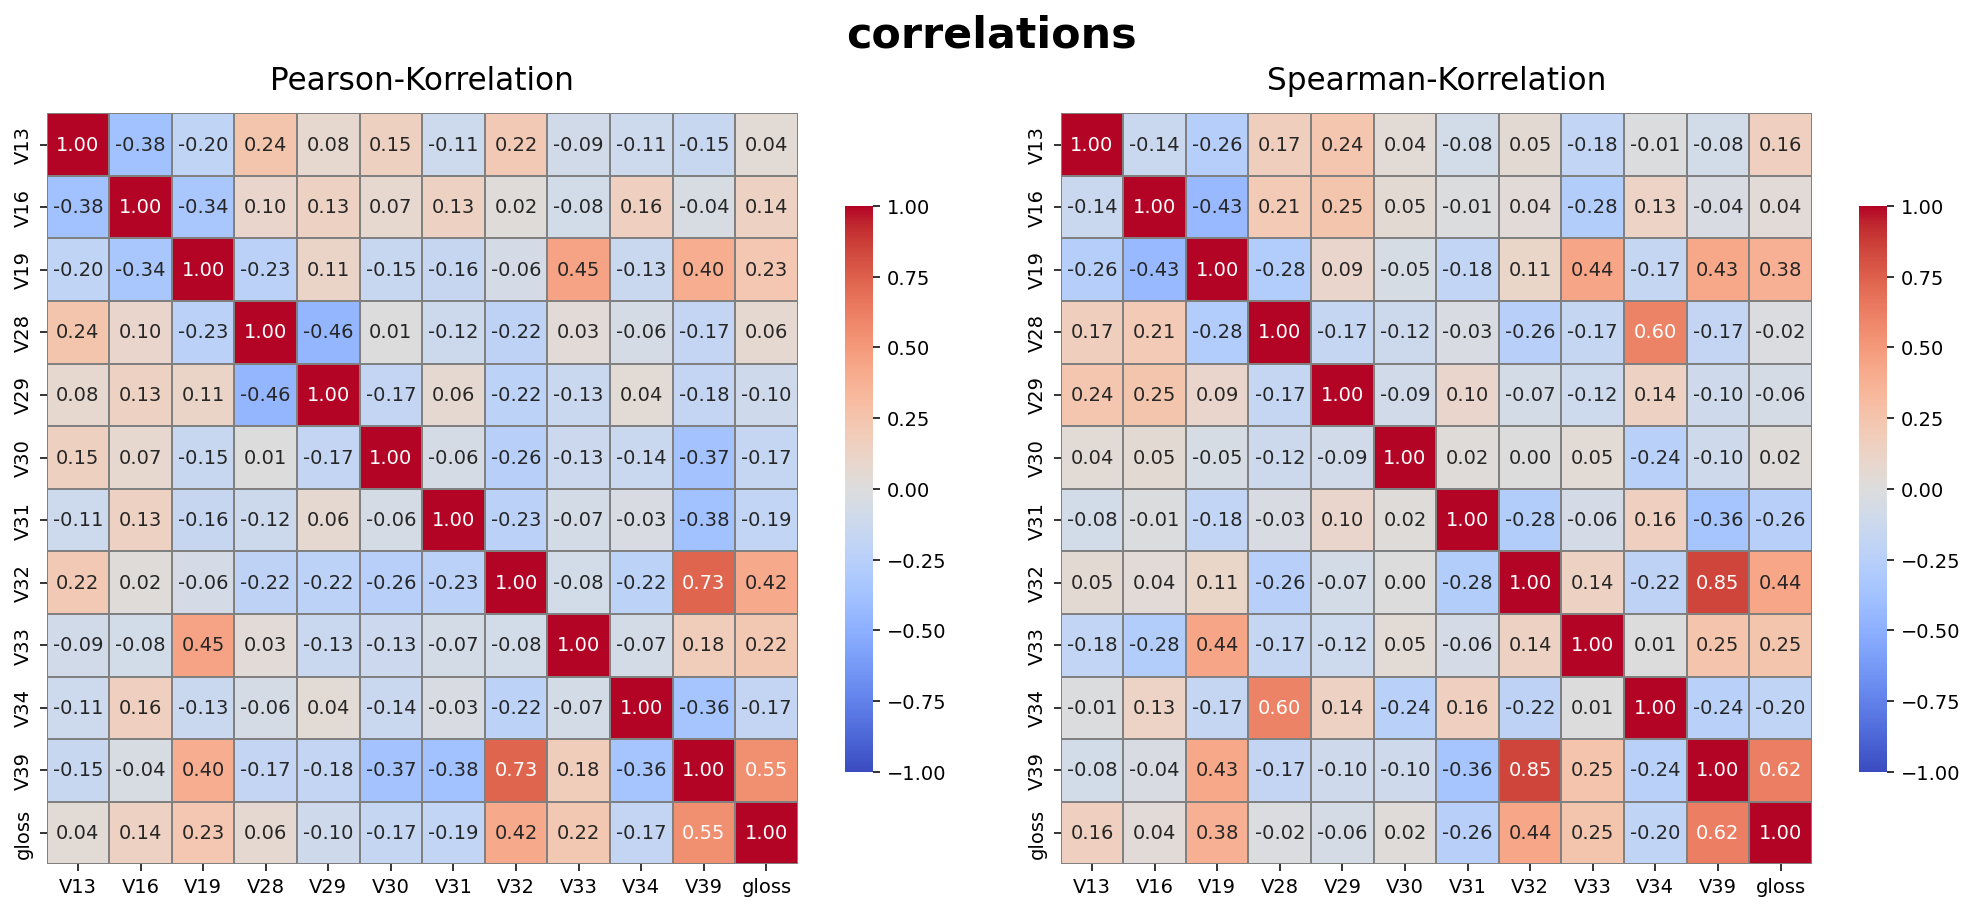

In [58]:
# --- Select numeric columns only ---
numeric_df = df_raw.select_dtypes(include=[np.number])

# --- Correlation calculation ---
methods = ["pearson", "spearman"]
correlation_matrices = {m: numeric_df.corr(method=m) for m in methods}

# --- Plot ---
fig, axes = plt.subplots(ncols=2, figsize=(18, 7), dpi=140)
fig.suptitle("correlations", fontsize=22, fontweight="bold")
plt.subplots_adjust(wspace=0.08)

color_map = "coolwarm"

for ax, method in zip(axes, methods):
    sns.heatmap(
        correlation_matrices[method],
        ax=ax,
        annot=True,
        cmap=color_map,
        linewidths=0.8,
        linecolor="gray",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        square=True,
        cbar_kws={"shrink": 0.75}
    )
    ax.set_title(f"{method.capitalize()}‑Korrelation", fontsize=16, pad=12)

plt.show()

In [59]:
# --- Parameters ---
RANDOM_STATE = 1
TEST_RATIO = 0.10

# --- Separate target and features ---
target_col = df_raw.columns[-1]
y = df_raw[target_col]
X_raw = df_raw.drop(columns=target_col)

# --- Identify categorical (object) columns for encoding ---
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()

# --- One-Hot Encoding with ColumnTransformer ---
encoder = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), cat_cols)
    ],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X_raw)

# --- Headers for transformed data ---
X_headers = encoder.get_feature_names_out()
n_rows, n_cols = X_encoded.shape

print(f"Target (y) column:\n{target_col}\n")
print(f"Feature columns ({n_cols}):\n{np.array(X_headers)}\n")

# --- Train/Test split ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_encoded, y,
    test_size=TEST_RATIO,
    random_state=RANDOM_STATE,
    shuffle=True
)

# --- Standardize based on train/val only ---
scaler = StandardScaler()
X_train_val_z = scaler.fit_transform(X_train_val)
X_test_z = scaler.transform(X_test)

# --- Outlier filtering (values < 11,000) ---
mask_inlier = y_train_val < 11000
X_train_val_z_in = X_train_val_z[mask_inlier]
X_train_val_in = X_train_val[mask_inlier]
y_train_val_in = y_train_val[mask_inlier]

X_train_val_z_out = X_train_val_z[~mask_inlier]
X_train_val_out = X_train_val[~mask_inlier]
y_train_val_out = y_train_val[~mask_inlier]

Target (y) column:
gloss

Feature columns (35):
['ohe__V15_HMW 2' 'ohe__V15_HMW 3' 'ohe__V15_HMW 4' 'ohe__V15_HMW 5'
 'ohe__V15_HMW 6' 'ohe__V15_LMW 1' 'ohe__V15_LMW 2' 'ohe__V15_LMW 3'
 'ohe__V18_HMW 3' 'ohe__V18_HMW 4' 'ohe__V18_HMW 5' 'ohe__V18_HMW 6'
 'ohe__V18_LMW 1' 'ohe__V18_LMW 2' 'ohe__V18_LMW 4' 'ohe__V18_LMW 5'
 'ohe__V18_LMW 6' 'ohe__V18_MMW 1' 'ohe__V18_MMW 2' 'ohe__V18_nan'
 'ohe__V21_LMW 3' 'ohe__V21_LMW 6' 'ohe__V21_LMW 7' 'ohe__V21_nan'
 'remainder__V13' 'remainder__V16' 'remainder__V19' 'remainder__V28'
 'remainder__V29' 'remainder__V30' 'remainder__V31' 'remainder__V32'
 'remainder__V33' 'remainder__V34' 'remainder__V39']



In [60]:
def compute_error_metrics(model, X_train, X_test, X_out, y_train, y_test):
    """Calculate predictions, residuals, and common regression error metrics."""
    # Predictions
    y_pred_out = model.predict(X_out) if len(X_out) else np.nan
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Residuals
    errors_train = y_train - y_pred_train
    errors_test = y_test - y_pred_test

    # RMSE (manual sqrt to avoid 'squared' param issues)
    rmse = {
        lbl: np.sqrt(metrics.mean_squared_error(y, y_hat))
        for lbl, y, y_hat in [
            ("TrVal", y_train, y_pred_train),
            ("Test", y_test, y_pred_test)
        ]
    }

    # R²
    r2 = {
        lbl: metrics.r2_score(y, y_hat)
        for lbl, y, y_hat in [
            ("TrVal", y_train, y_pred_train),
            ("Test", y_test, y_pred_test)
        ]
    }

    # NRMSE
    nrmse = {
        lbl: 1 - np.sqrt(abs(r2_val - 1))
        for lbl, r2_val in [
            ("TrVal", r2["TrVal"]),
            ("Test", r2["Test"])
        ]
    }

    return model, y_pred_train, y_pred_test, y_pred_out, errors_train, errors_test, {
        "RMSE": rmse,
        "NRMSE": nrmse,
        "R2": r2
    }

In [61]:
def iterative_ols_feature_reduction(headers, X_train, X_test, X_outliers, y_train, y_test):
    """
    Iteratively fits an OLS model and removes features with the highest p-value > 0.05
    until all remaining features are statistically significant.
    """
    # Set up feature names
    if headers is not None and len(headers) > 0:
        feature_names = headers.copy()
    else:
        feature_names = [f"x{i}" for i in range(1, X_train.shape[1] + 1)]
    
    # Add constant column
    X_train_wc = sm.add_constant(X_train, has_constant='add')
    X_test_wc = sm.add_constant(X_test, has_constant='add')
    X_out_wc = sm.add_constant(X_outliers, has_constant='add') if len(X_outliers) else []

    # Iteratively remove features with highest p-value > 0.05
    while True:
        model = sm.OLS(y_train, X_train_wc)
        model.exog_names[1:] = feature_names
        fitted = model.fit()

        fitted_model, y_pred_train, y_pred_test, y_pred_out, e_train, e_test, metrics_dict = compute_error_metrics(
            fitted, X_train_wc, X_test_wc, X_out_wc, y_train, y_test
        )

        pvalues = fitted.summary2().tables[1]['P>|t|']

        if pvalues.max() <= 0.05:
            break

        # Find and drop the least significant feature
        drop_idx = np.argmax(pvalues)
        feature_names = np.delete(feature_names, drop_idx - 1)  # adjust for constant at index 0
        X_train_wc = np.delete(X_train_wc, drop_idx, axis=1)
        X_test_wc = np.delete(X_test_wc, drop_idx, axis=1)
        if len(X_outliers):
            X_out_wc = np.delete(X_out_wc, drop_idx, axis=1)

    print(fitted.summary())
    final_n_features = len(feature_names)

    return final_n_features, X_train_wc, X_test_wc, X_out_wc, y_pred_train, y_pred_test, y_pred_out, e_train, e_test, metrics_dict


def print_model_results(model_name, n_features, metrics_dict, note=""):
    """Prints key metrics in formatted table style."""
    print(
        f"{model_name:>15}: {n_features:8d} | "
        f"{metrics_dict['R2']['TrVal']:9.3f} | {metrics_dict['R2']['Test']:9.3f} | "
        f"{metrics_dict['RMSE']['TrVal']:11.3f} | {metrics_dict['RMSE']['Test']:11.3f} | "
        f"{metrics_dict['NRMSE']['TrVal']:12.3f} | {metrics_dict['NRMSE']['Test']:12.3f} | {note}"
    )

With outlier:
                            OLS Regression Results                            
Dep. Variable:                  gloss   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     42.46
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           1.37e-18
Time:                        12:03:34   Log-Likelihood:                -410.10
No. Observations:                  52   AIC:                             846.2
Df Residuals:                      39   BIC:                             871.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5778.8462    1

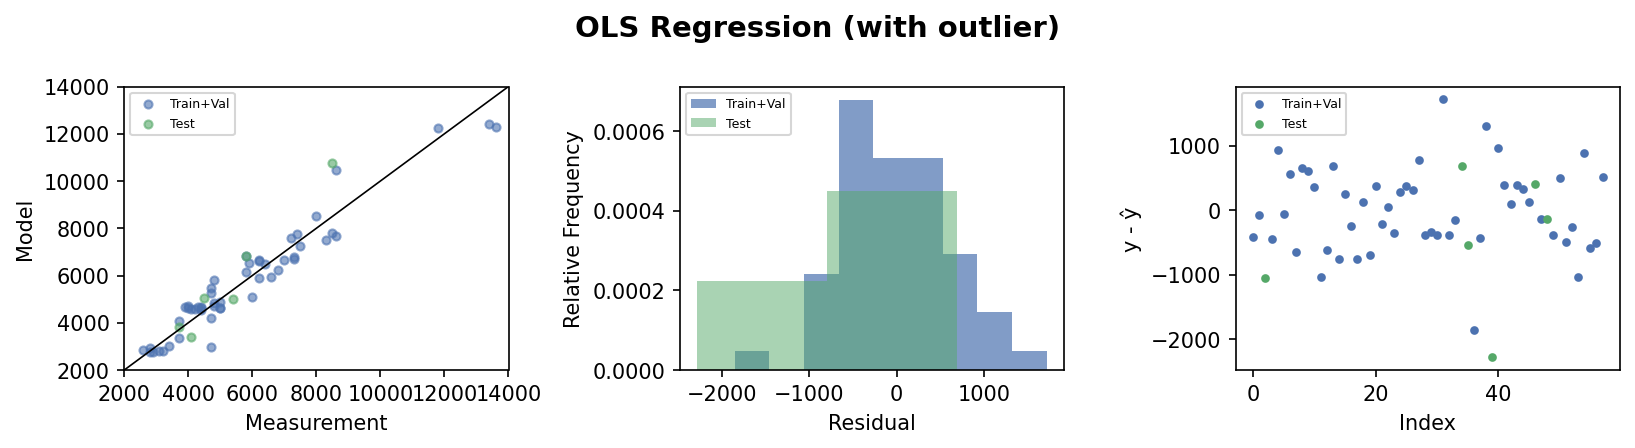

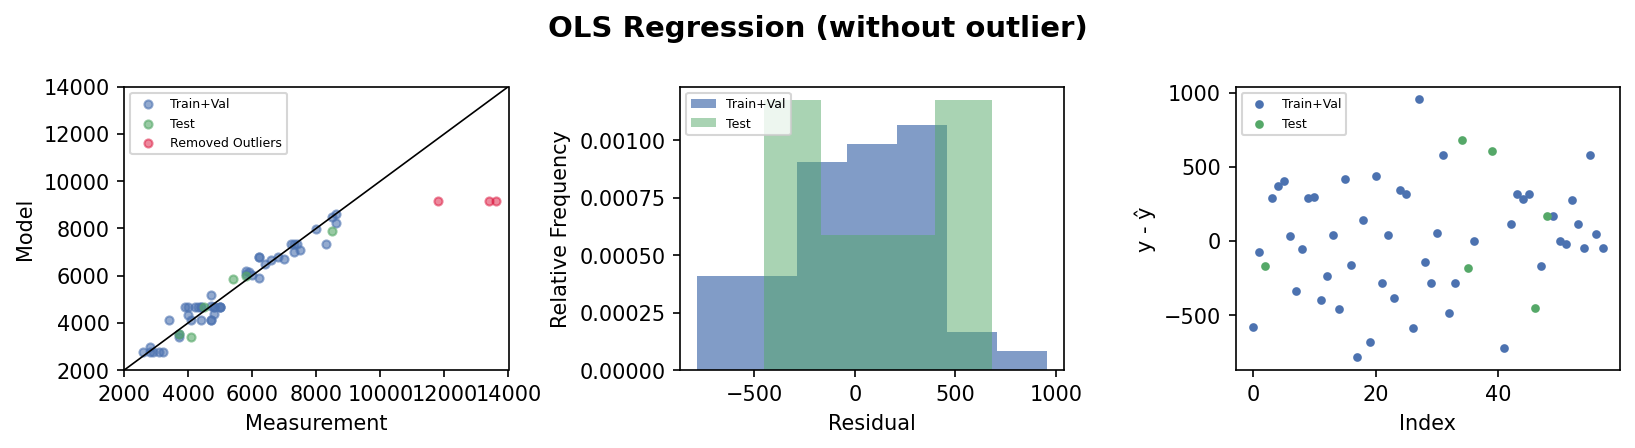



            Num. Params | R² (Train+Val) | R² (Test) | RMSE (Train+Val) |   RMSE (Test) | NRMSE (Train+Val) |   NRMSE (Test) | Comment
            OLS:       12 |     0.929 |     0.521 |     643.913 |    1098.740 |        0.733 |        0.308 | with outlier
            OLS:       14 |     0.952 |     0.926 |     369.608 |     432.948 |        0.780 |        0.727 | without outlier


In [63]:
print("With outlier:")
(
    n_with,
    X_trainval_wc_with,
    X_test_wc_with,
    _,
    y_pred_train_with,
    y_pred_test_with,
    _,
    err_train_with,
    err_test_with,
    metrics_with
) = iterative_ols_feature_reduction(
    X_headers,
    X_train_val_z,
    X_test_z,
    [],
    y_train_val,
    y_test
)

print("\nWithout outlier:")
(
    n_without,
    X_trainval_wc_without,
    X_test_wc_without,
    X_out_wc_without,
    y_pred_train_without,
    y_pred_test_without,
    y_pred_out_without,
    err_train_without,
    err_test_without,
    metrics_without
) = iterative_ols_feature_reduction(
    X_headers,
    X_train_val_z_in,
    X_test_z,
    X_train_val_z_out,
    y_train_val_in,
    y_test
)

# --- Plots ---
plot_results(
    "OLS Regression (with outlier)",
    y_train_val,
    y_test,
    [],
    y_pred_train_with,
    y_pred_test_with,
    [],
    err_train_with,
    err_test_with
)
plot_results(
    "OLS Regression (without outlier)",
    y_train_val_in,
    y_test,
    y_train_val_out,
    y_pred_train_without,
    y_pred_test_without,
    y_pred_out_without,
    err_train_without,
    err_test_without
)

# --- Summary Table ---
print(
    "\n\n{:>23} | {:>9} | {:>9} | {:>13} | {:>13} | {:>14} | {:>14} | {}".format(
        "Num. Params",
        "R² (Train+Val)",
        "R² (Test)",
        "RMSE (Train+Val)",
        "RMSE (Test)",
        "NRMSE (Train+Val)",
        "NRMSE (Test)",
        "Comment"
    )
)
print_model_results("OLS", n_with, metrics_with, "with outlier")
print_model_results("OLS", n_without, metrics_without, "without outlier")